In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# TODO: reassign functions to their new locations once notebooks and dev-dataloading merge
import gtc_functions

# from h3.dataloading.general_df_utils import (limit_df_spatial_range, 
#     calc_means_df_cols, station_availability)
# from h3.dataloading.noaa_six_hourly_processing import return_most_recent_events_by_name

In [3]:
# TODO: better common path solution. Lisanne's use of Owen's functions? Cambridge-hosted data server?
google_drive_personal_key = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/'

In [4]:
### LOAD IN RELEVANT DFS

# TODO: Lisanne's/Owen's method of file path finding
# xbd observation points
df_xbd_points_path = google_drive_personal_key + 'datasets/xBD_data/xbd_points_posthurr_reformatted.pkl'
df_xbd_points = pd.read_pickle(df_xbd_points_path)
# noaa 6-hourly
df_noaa_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/noaa_hurricanes.pkl'
df_noaa_weather = pd.read_pickle(df_noaa_pkl_path)
# weather stations
df_stations_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/weather_stations.pkl'
df_stations = pd.read_pickle(df_stations_pkl_path)
# noaa six-hourly closest to each xbd point
df_noaa_xbd_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/xbd_obs_noaa_six_hourly.pkl'
df_noaa_xbd_weather = pd.read_pickle(df_noaa_xbd_pkl_path)
# weather stations infor for each xbd point
df_stations_xbd_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/xbd_stations_info.pkl'
df_stations_xbd = pd.read_pickle(df_stations_xbd_pkl_path)

## Visualise stations data availability

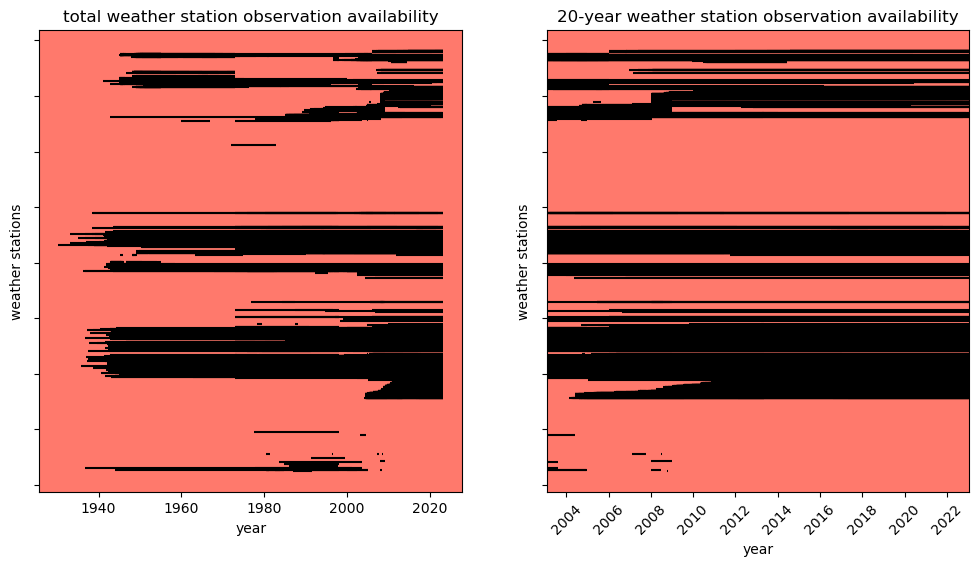

In [5]:
# set number of stations to include (helps visualise data availability): -1 = all
num_stations = -1

fig, axs = plt.subplots(1,2,figsize=[12,6]);
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].set_xlabel('year'), axs[i].set_ylabel('weather stations')
    axs[i].hlines(df_stations.index[:num_stations], 
        df_stations.begin[:num_stations], df_stations.end[:num_stations],
    color='k')

    # formatting
    axs[i].set_facecolor('xkcd:salmon')
    axs[i].set_yticklabels([])

axs[0].set_title('total weather station observation availability');

axs[1].set_xlim((max(df_stations.end[:num_stations])-pd.Timedelta(20*365,'d')),max(df_stations.end[:num_stations]));
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_title('20-year weather station observation availability');

### Plot geographical distribution of weather stations

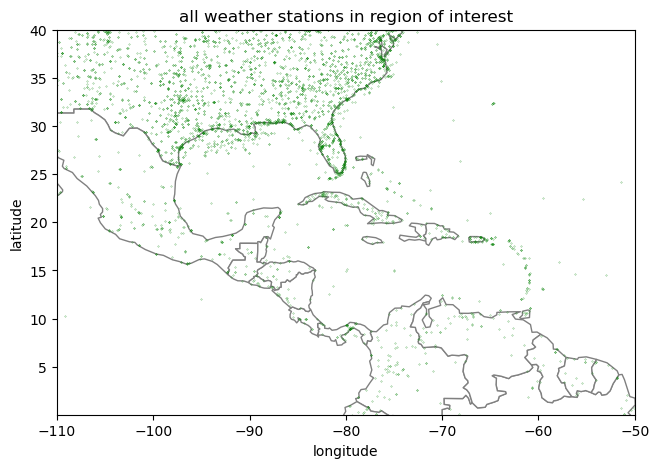

In [6]:
### PLOT WEATHER STATIONS

gdf_stations = gpd.GeoDataFrame(df_stations,geometry=gpd.points_from_xy(df_stations.lon,df_stations.lat))

# fetch worldmap and format plot size
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
plt.rcParams['figure.figsize'] = [13, 7]

fig, ax = plt.subplots(figsize=[12,5]);
ax.set_xlabel('longitude'), ax.set_ylabel('latitude')
world.plot(ax=ax,color='white',edgecolor='grey')
gdf_stations.plot(ax=ax,color='green',markersize=0.05,alpha=0.8);

# formatting
ax.set_xlim([min(gdf_stations['lon']),max(gdf_stations['lon'])]);
ax.set_ylim([min(gdf_stations['lat']),max(gdf_stations['lat'])]);
ax.set_title('all weather stations in region of interest');


## Visualise hurricane data

In [7]:
# TODO: graphs
# historic trend of hurricane events (for powerpoint)

max_strength_by_tag = df_noaa_weather.groupby(by='tag')['strength'].max()
# x = df_noaa_weather.groupby(by='tag')['date'].min()
# plt.bar(x=x,y=grouped_by_tag)
df = pd.DataFrame({'strength': max_strength_by_tag, 'date': df_noaa_weather.groupby(by='tag')['date'].min()})
df.head()

,strength,date
tag,,
##AL011851,1,1851-06-25 00:00:00
AL011852,3,1852-08-19 00:00:00
AL011853,0,1853-08-05 12:00:00
AL011854,1,1854-06-25 00:00:00
AL011855,2,1855-08-06 12:00:00


In [8]:
# exclude rows with maximum strength as 0 (not a hurricane)
df = df[df['strength'] != 0]

In [9]:
df

,strength,date
tag,,
##AL011851,1,1851-06-25 00:00:00
AL011852,3,1852-08-19 00:00:00
AL011854,1,1854-06-25 00:00:00
AL011855,2,1855-08-06 12:00:00
AL011856,4,1856-08-09 00:00:00
...,...,...
AL282020,3,2020-10-24 12:00:00
AL291969,1,1969-11-20 12:00:00
AL292020,4,2020-10-31 18:00:00


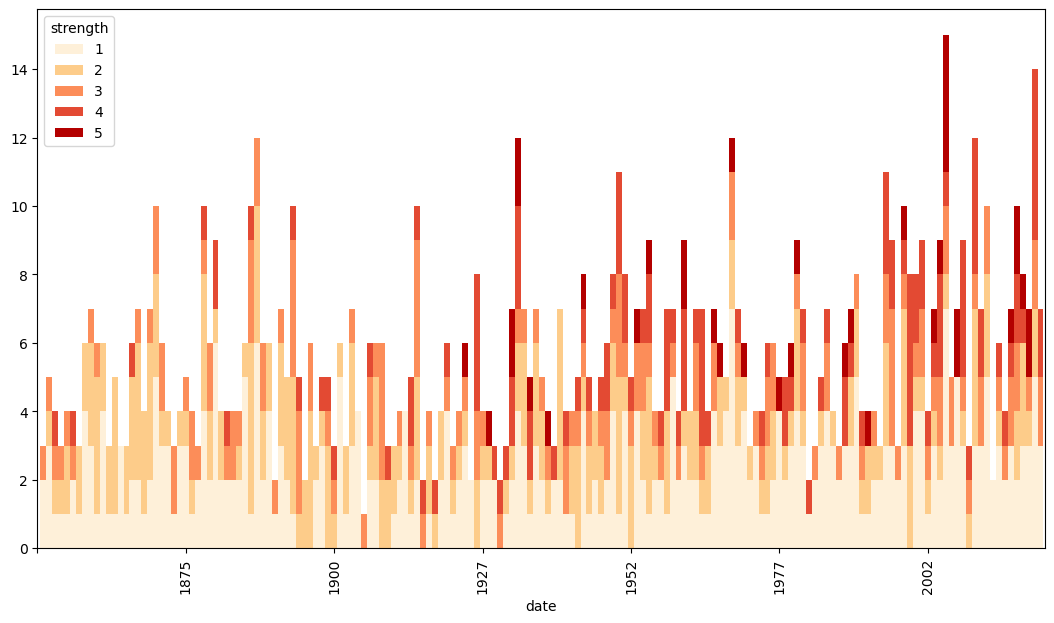

In [10]:
fig,ax = plt.subplots()

# group the data by year and strength, and count the number of events
grouped = df.groupby([df['date'].dt.year, 'strength']).size().reset_index(name='count')
five_colours = ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']
# pivot the data to create a stacked bar chart
pivot = grouped.pivot(index='date', columns='strength', values='count')
# TODO: modify to remove spaces between bars
pivot.plot(ax=ax, kind='bar', stacked=True, color=five_colours,width=1)
ax.set_xticks(np.arange(-1, len(pivot)+1, 25));
plt.show()


In [11]:
pivot

strength,1,2,3,4,5
date,,,,,
1851,2.0,NaN,1.0,NaN,NaN
1852,3.0,1.0,1.0,NaN,NaN
1853,1.0,1.0,1.0,1.0,NaN
1854,1.0,1.0,1.0,NaN,NaN
1855,1.0,2.0,1.0,NaN,NaN
...,...,...,...,...,...
2017,2.0,2.0,2.0,2.0,2.0
2018,3.0,3.0,NaN,1.0,1.0
2019,3.0,1.0,1.0,NaN,2.0


In [12]:
damage_file = google_drive_personal_key + 'datasets/EFs/weather_data/hurricane_damages/events-US-1980-2022.csv'

df_damage_data = pd.read_csv(damage_file,skiprows=[0])
df_damage_data.head(2)


,Name,Disaster,Begin Date,End Date,Total CPI-Adjusted Cost (Millions of Dollars),Deaths
0,Hurricane Allen (August 1980),Tropical Cyclone,19800807,19800811,2106.4,13
1,Hurricane Alicia (August 1983),Tropical Cyclone,19830817,19830820,8910.0,21


In [16]:
### Processing damage data

# standardise
df_damage_data_proc = gtc_functions.standardise_dfs(df_damage_data)
# remove any events which aren't hurricanes (also helps with following isolation of names, since sentences now same length)
df_damage_data_proc = df_damage_data[df_damage_data_proc['name'].str.contains('Hurricane')]
# remove non-name info from 'name' column and make upper case
df_damage_data_proc['name'] = df_damage_data_proc['name'].apply(lambda x: x.split()[1].upper())
# format date columns to dt objects
df_damage_data_proc['begin_date'] = pd.to_datetime(df_damage_data_proc['begin_date'], format='%Y%m%d')
df_damage_data_proc['end_date'] = pd.to_datetime(df_damage_data_proc['end_date'], format='%Y%m%d')

df_damage_data_proc.head()

/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_24758/4036841814.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_damage_data_proc['name'] = df_damage_data_proc['name'].apply(lambda x: x.split()[1].upper())
/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_24758/4036841814.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_damage_data_proc['begin_date'] = pd.to_datetime(df_damage_data_proc['begin_date'], format='%Y%m%d')
/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykern

,name,disaster,begin_date,end_date,total_cpi-adjusted_cost_(millions_of_dollars),deaths
0,ALLEN,Tropical Cyclone,1980-08-07,1980-08-11,2106.4,13
1,ALICIA,Tropical Cyclone,1983-08-17,1983-08-20,8910.0,21
2,ELENA,Tropical Cyclone,1985-08-30,1985-09-03,3580.9,4
3,GLORIA,Tropical Cyclone,1985-09-26,1985-09-28,2354.4,11
4,JUAN,Tropical Cyclone,1985-10-27,1985-10-31,4100.9,63


In [36]:
# limit df to only row for each event corresponding to the maximum event strength
df_max_strengths = df_noaa_weather.loc[df_noaa_weather.groupby('tag')['strength'].idxmax()]

0    970
1    387
2    252
3    162
4    127
5     38
Name: strength, dtype: Int64

In [37]:
# limit noaa weather to include only those hurricanes (by name) which occurred after 1980
df_lim_eighties_hurricanes = df_max_strengths[(df_max_strengths['date'] >= pd.Timestamp('1980')) & df_max_strengths['strength'] > 0].drop_duplicates(subset='tag',keep='first')
df_lim_eighties_hurricanes.head()

1    119
3     47
5     19
Name: strength, dtype: Int64

In [24]:
sum(df_lim_eighties_hurricanes.strength)

287

In [149]:
# match events based on name and date N.B. matching noaa df to damages df since noaa larger
# limit noaa df to those with same name as damage data
df_comb_prep = df_lim_eighties_hurricanes[df_lim_eighties_hurricanes.name.apply(lambda x: np.any(np.in1d(x, df_damage_data_proc.name.tolist())))] # no strength nans

# set start time as indexes
df_comb_prep.set_index('date',inplace=True)
df_damage_data_proc_comb = df_damage_data_proc.copy()
df_damage_data_proc_comb.set_index('begin_date',inplace=True)

# # create a new dataframe with a complete range of dates
# start_date = df_merged['begin_date'].min().replace(day=1, month=1)
# end_date = df_merged['begin_date'].max().replace(day=31, month=12)
# new_dates_idx = pd.date_range(start=start_date, end=end_date, freq='Y')

# df_damage_data_proc_comb = df_damage_data_proc_comb.reindex(new_dates_idx, fill_value=0)

# print(df_damage_data_proc_comb.asfreq('Y'))

tol = pd.Timedelta(30, 'd')
df_merged = pd.merge_asof(left=df_damage_data_proc_comb,right=df_comb_prep.sort_values('date'),right_index=True,left_index=True,direction='nearest',tolerance=tol)
# reset index to eliminate multilevel-ness TODO: nicer way for this?
# df_merged = df_merged.resample('Y').median()

df_merged.reset_index(inplace=True)
df_merged.head()

,begin_date,name_x,disaster,end_date,total_cpi-adjusted_cost_(millions_of_dollars),deaths,tag,name_y,num_entries,record_id,...,r_se_50,r_nw_50,r_sw_50,r_ne_64,r_se_64,r_nw_64,r_sw_64,r_max_wind,strength,geometry
0,1980-08-07,ALLEN,Tropical Cyclone,1980-08-11,2106.4,13,AL041980,ALLEN,46.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,POINT (-66.7 14.8)
1,1983-08-17,ALICIA,Tropical Cyclone,1983-08-20,8910.0,21,AL031983,ALICIA,25.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,POINT (-95 28.9)
2,1985-08-30,ELENA,Tropical Cyclone,1985-09-03,3580.9,4,AL051985,ELENA,33.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,POINT (-83.9 28.6)
3,1985-09-26,GLORIA,Tropical Cyclone,1985-09-28,2354.4,11,AL051985,ELENA,33.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,POINT (-83.9 28.6)
4,1985-10-27,JUAN,Tropical Cyclone,1985-10-31,4100.9,63,AL121985,JUAN,29.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,POINT (-91.2 27.8)


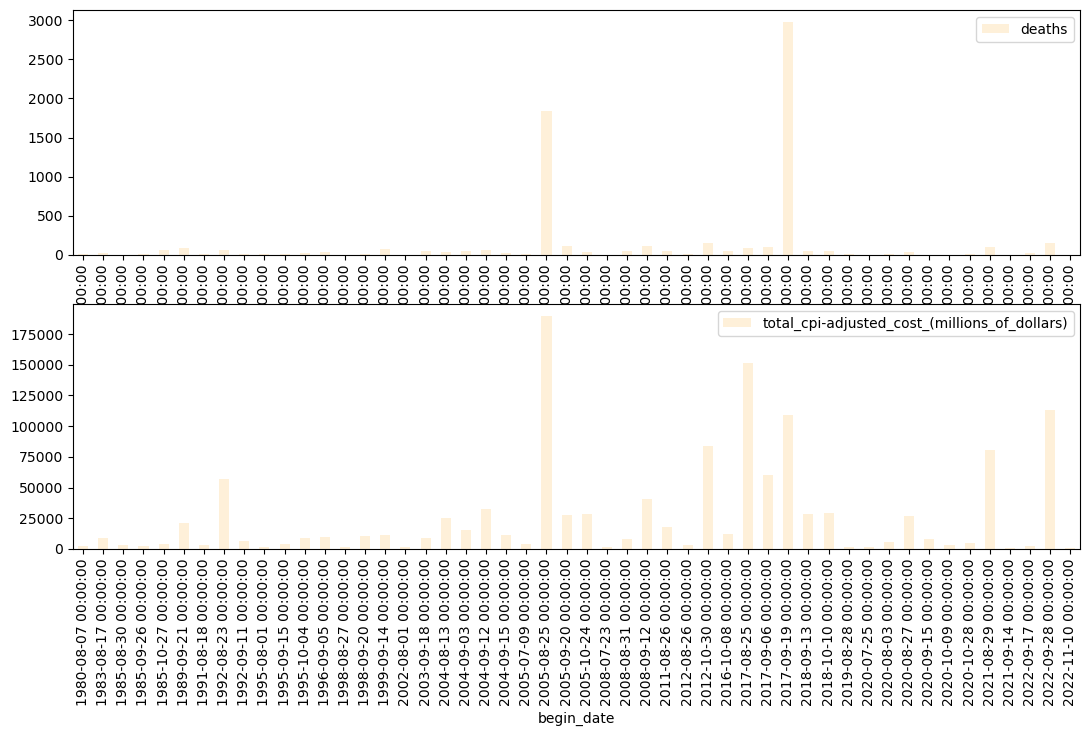

In [151]:
# plot
fig,axes = plt.subplots(2,1)

df_merged[['begin_date','deaths']].plot(ax=axes[0], x='begin_date', kind='bar', stacked=False, color=five_colours)
df_merged[['begin_date','total_cpi-adjusted_cost_(millions_of_dollars)']].plot(ax=axes[1], x='begin_date', kind='bar', stacked=False, color=five_colours)

# ax.set_xticks(np.arange(-1, len(pivot)+1, 25));
plt.show()

N.B. since deaths are comparatively rare, there isn't much of a discernable trend. Could be useful to consider whether deaths are a pattern of the country.

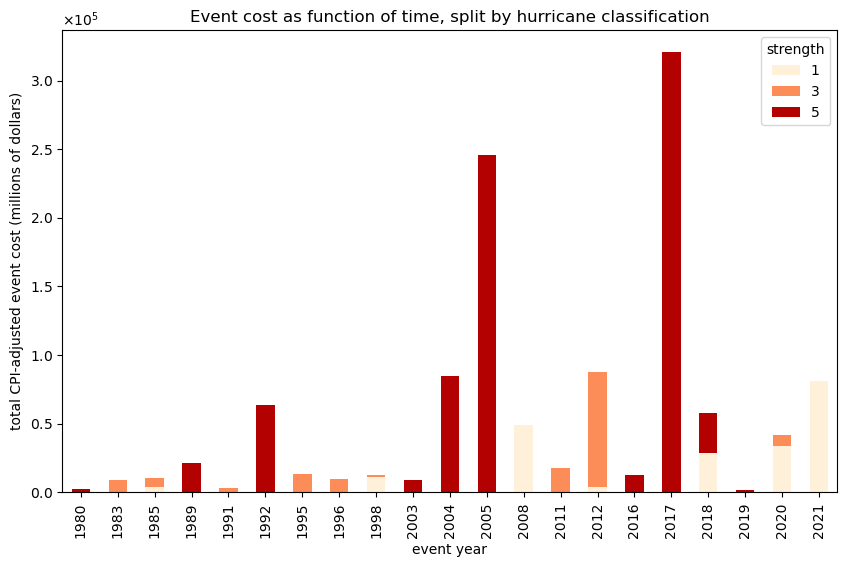

In [152]:
# group by event year and event strength and sum the damage amount
grouped = df_merged.groupby([df_merged['begin_date'].dt.year, 'strength']).sum(numeric_only=True).reset_index()
# pivot the table so that event strength is the column and event year is the index
pivoted = grouped.pivot(index='begin_date', columns='strength', values='total_cpi-adjusted_cost_(millions_of_dollars)')

# plot stacked bar chart
ax_damage = pivoted.plot(kind='bar', stacked=True, figsize=(10, 6), color=five_colours[::2])

# formatting
ax_damage.set_xlabel('event year');
ax_damage.set_ylabel('total CPI-adjusted event cost (millions of dollars)');
ax_damage.set_title('Event cost as function of time, split by hurricane classification');

import matplotlib.ticker as mticker

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,2))
ax_damage.yaxis.set_major_formatter(formatter)

Bizarrely, none of the damage-recorded events are classified as strengths 2 or 4. NaNs in strength column (excluded from plot) result from events matching between NOAA weather and damage quantity data failing. Slightly troubling, given that the data is all from the [same organisation](https://www.ncei.noaa.gov/access/billions/).

In [ ]:
### TODO: look at economic damage as y axis, and colour code by strength

# artificial discretisation of data into years also arbitrary. Not necessarily needing spaces.
# superimpose grid for time
#  

In [ ]:
pivot.head()

strength,1,2,3,4,5
date,,,,,
1851,2.0,NaN,1.0,NaN,NaN
1852,3.0,1.0,1.0,NaN,NaN
1853,1.0,1.0,1.0,1.0,NaN
1854,1.0,1.0,1.0,NaN,NaN
1855,1.0,2.0,1.0,NaN,NaN


In [ ]:
pivot['strength']

KeyError: 'strength'

In [ ]:
full_years_df = pd.DataFrame({'year': range(['year'].min(), df['year'].max() + 1)})
pivot


In [ ]:
# merge the new DataFrame with the original DataFrame
merged_df = pd.merge(df, full_years_df, on='year', how='right')

# sort the merged DataFrame by year
merged_df = merged_df.sort_values(by='year')

In [ ]:
np.arange(0, len(pivot)+1, 25)

In [ ]:
np.arange(-1, len(pivot)+1, 25)

In [ ]:
sns.barplot(data=df,x='date',hue='strength')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# create a sample DataFrame
data = {'time': pd.date_range('2022-01-01', periods=30, freq='D'),
        'strength': [1, 2, 3, 2, 1, 3, 1, 2, 3, 2, 1, 2, 1, 3, 1, 2, 3, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3],
        'event': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]}

df = pd.DataFrame(data)

# group the data by year and strength, and count the number of events
grouped = df.groupby([df['time'].dt.year, 'strength']).size().reset_index(name='count')

# pivot the data to create a stacked bar chart
pivot = grouped.pivot(index='time', columns='strength', values='count')
pivot.plot(kind='bar', stacked=True, color=['red', 'green', 'blue'])

# set the chart title and labels
plt.title('Number of Events by Year and Strength')
plt.xlabel('Year')
plt.ylabel('Number of Events')

# show the chart
plt.show()


## Visualise hurricane tracks for xBD events

In [ ]:
# restrict hurricanes df to xbd events
xbd_hurricane_names = ['MICHAEL','MATTHEW','FLORENCE','HARVEY']
df_xbd_hurricanes_noaa = gtc_functions.return_most_recent_events_by_name(df_noaa_weather,xbd_hurricane_names)

# number of 6-hour intervals spanning xbd hurricanes in the Atlantic
num_6s = len(df_xbd_hurricanes_noaa)
print('number of 6-hour intervals spanning xbd hurricanes in the Atlantic: ', num_6s)
# number of 1-hour intervals spanning hurricanes in the Atlantic
# approximate since coarse (may have a couple of hours of weather caused the same
# storm on either end)
num_hourly = num_6s * 6
print('approximate number of 1-hour intervals spanning xbd hurricanes in the Atlantic: ', num_hourly)

In [ ]:
### PLOT HURRICANE TRACKS BY EVENT

# plot xbd locations and relevant NOAA datapoints
fig, axs = plt.subplots(2,2,figsize=[12,12]);
axs = axs.ravel()

# fetch worldmap and format plot size
# TODO: common path – and standardise with what others are using.
# Credit: World Bank https://datacatalog.worldbank.org/search/dataset/0038272/World-Bank-Official-Boundaries
gdf_coastlines = gpd.read_file(google_drive_personal_key + 'datasets/EFs/weather_data/WB_Coastlines.geojson')
plt.rcParams['figure.figsize'] = [13, 7]

for i,name in enumerate(xbd_hurricane_names):
    axs[i].set_title(f'{name}')
    axs[i].set_xlabel('longitude'), axs[i].set_ylabel('latitude')
    gdf_coastlines.plot(ax=axs[i],color='grey',alpha=1,linewidth=0.5)

    gdf_xbd_points = gpd.GeoDataFrame(df_xbd_points[df_xbd_points['disaster_name']==name])
    gdf_xbd_hurricanes_noaa = gpd.GeoDataFrame(df_xbd_hurricanes_noaa[df_xbd_hurricanes_noaa['name']==name])

    gdf_xbd_points.plot(ax=axs[i],color='red',markersize=0.5,alpha=1);
    gdf_xbd_hurricanes_noaa.plot(ax=axs[i],color='blue',markersize=20,alpha=0.3);

    # generate list of observation coordinates
    coords = list(gdf_xbd_points['geometry'])+list(gdf_xbd_hurricanes_noaa['geometry'])
    lats = [pt.y for pt in coords]
    lons = [pt.x for pt in coords]
    # restrict axes limits to zoom in on available data
    axs[i].set_ylim(min(lats),max(lats))
    axs[i].set_xlim(min(lons),max(lons))

In [ ]:
df_xbd_hurricanes_noaa.columns

In [ ]:
# TODO: histograms of hurricane parameters
# TODO: visualise prevalence of missing values

### Superimpose hurricane tracks and weather stations, investigating local weather station availability

In [ ]:
# plot all weather stations against hurricane track and xbd points, zoomed into area of interest
distance_buffer = 5

# BY EVENT
# plot xbd locations and relevant NOAA datapoints
fig, axs = plt.subplots(2,2,figsize=[12,12]);
axs = axs.ravel()

# format plot size
plt.rcParams['figure.figsize'] = [13, 7]

for i,name in enumerate(xbd_hurricane_names):
    axs[i].set_title(f'{name}')
    axs[i].set_xlabel('longitude'), axs[i].set_ylabel('latitude')
    gdf_coastlines.plot(ax=axs[i],color='grey',alpha=0.5)

    # xbd observations
    gdf_xbd_points = gpd.GeoDataFrame(df_xbd_points[df_xbd_points['disaster_name']==name])
    gdf_xbd_points.plot(ax=axs[i],color='red',markersize=0.5,alpha=0.5,label='xBD point');

    # noaa 6-hourly weather observations
    gdf_xbd_hurricanes_noaa = gpd.GeoDataFrame(df_xbd_hurricanes_noaa[df_xbd_hurricanes_noaa['name']==name])
    gdf_xbd_hurricanes_noaa.plot(ax=axs[i],color='blue',markersize=50,alpha=0.5,label='NOAA 6-hourly hurricane observation');

    # calculate average lat-lon 
    av_lat,av_lon = gtc_functions.calc_means_df_cols(gdf_xbd_points,['lat','lon'])
    # weather stations
    gdf_event_stations = gtc_functions.limit_df_spatial_range(gdf_stations,[av_lat,av_lon],distance_buffer)

    # inactive weather stations
    gdf_event_stations_inactive = gtc_functions.station_availability(gdf_event_stations,gdf_xbd_hurricanes_noaa,available=False)
    gdf_event_stations_inactive.plot(ax=axs[i],color='darkorange',markersize=10,label=f'inactive stations: {len(gdf_event_stations_inactive)}')

    # active weather stations
    gdf_event_stations_active = gtc_functions.station_availability(gdf_event_stations,gdf_xbd_hurricanes_noaa,available=True)
    gdf_event_stations_active.plot(ax=axs[i],color='lime',markersize=10,alpha=1,label=f'active stations: {len(gdf_event_stations_active)}')

    # ensure that at least 3 hurricane observation points are in the image
    limited_weather_points = gtc_functions.limit_df_spatial_range(gdf_xbd_hurricanes_noaa,[av_lat,av_lon],min_number=3)
    # generate list of observation coordinates, zoomed on xbd points region
    coords = list(gdf_xbd_points['geometry'])+list(gdf_event_stations['geometry'])+list(limited_weather_points['geometry'])
    lats = [pt.y for pt in coords]
    lons = [pt.x for pt in coords]
    # restrict axes limits to zoom in on available data
    axs[i].set_ylim(min(lats),max(lats))
    axs[i].set_xlim(min(lons),max(lons))
    axs[i].legend()


The CMORPH weather data is at a consistent 0.25 degree resolution for all geographical regions. Using this avoids the varying proximity of weather stations to the xBD datapoints seen above, and bypasses the data interpolation steps necessary to get the weather station data into a workable format. 

The poor data seen in the weather stations data raises questions as to the validity of GaLeNet's use of the same data via the OpenWeatherMap API...

In [ ]:
# compare distances between NOAA observations and weather station observations
# relative to xbd points

# calculate average distances
av_noaa_xbd_distance = df_noaa_xbd_weather['shortest_distance_to_track'].mean()
av_station_distance = df_stations_xbd['distance_to_closest'].mean()

fig,ax_hist = plt.subplots(figsize=[12,6])

# plot histogram
bins = np.linspace(0,250,50)
n_noaa,_,_ = ax_hist.hist(df_noaa_xbd_weather['shortest_distance_to_track'],bins,alpha=0.5,label='noaa observations');
n_stations,_,_ = ax_hist.hist(df_stations_xbd['distance_to_closest'],bins,alpha=0.5,label='station observations');

# plot means
ax_hist.vlines(av_noaa_xbd_distance,ymin=0,ymax=np.max(n_noaa+n_stations),color='k',label='mean noaa observation distance')
ax_hist.vlines(av_station_distance,ymin=0,ymax=np.max(n_noaa+n_stations),color='k',ls='--',label='mean station observation distance')

# formatting
ax_hist.set_title('Distance of closest weather datapoint for both weather station and six-hourly NOAA observations')
ax_hist.set_xlabel('distance (km)'), ax_hist.set_ylabel('count')
ax_hist.legend(loc='upper right');


The histogram above shows that the weather stations are on average further from the xBD observations than the NOAA observations, even though there is a relatively large number of very close stations. This may well be because for some events (likely Hurricane Matthew) had very few nearby stations. This is telling of the inequality of infrastructure between the US and the Caribbean islands. Yet another reason to use geography-agnostic CMORPH data.

In [ ]:
fig,ax_event_hist = plt.subplots(figsize=[12,6])

# TODO: break down histogram by event better
sns.histplot(ax=ax_event_hist,data=df_noaa_xbd_weather,x='shortest_distance_to_track',hue='name');
sns.histplot(ax=ax_event_hist,data=df_stations_xbd,x='distance_to_closest',hue='disaster_name',fill=False);


In [ ]:
# TODO: animate HURDAT best track data